In [9]:
import pandas as pd

In [1]:
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# -------- Sliding-window dataset --------

class SlidingWindowDataset(Dataset):
    """
    Turn a time series (T, N) into input/target windows for forecasting.

    series: np.ndarray, shape (T,) or (T, N)
    input_len: length of history window
    pred_len:  length of prediction horizon
    """
    def __init__(self, series, input_len, pred_len, stride=1):
        if series.ndim == 1:
            series = series[:, None]  # (T,) -> (T,1)
        T, N = series.shape

        X_list, y_list = [], []
        for start in range(0, T - input_len - pred_len + 1, stride):
            end = start + input_len
            target_end = end + pred_len
            X_list.append(series[start:end])        # (input_len, N)
            y_list.append(series[end:target_end])   # (pred_len, N)

        self.X = torch.from_numpy(np.stack(X_list)).float()  # (B, L, N)
        self.y = torch.from_numpy(np.stack(y_list)).float()  # (B, H, N)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------- Positional encodings --------

class SinusoidalPositionalEncoding(nn.Module):
    """Standard Transformer sinusoidal positional encoding."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # store as buffer so it's not a parameter but moves with .to(device)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]


class LearnablePositionalEncoding(nn.Module):
    """Learnable positional embeddings (one vector per index)."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pos_embed = nn.Embedding(max_len, d_model)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        """
        b, seq_len, _ = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(b, -1)
        return x + self.pos_embed(positions)


# -------- Time-series Transformer --------

class TimeSeriesTransformer(nn.Module):
    """
    Simple encoder-only Transformer for time-series forecasting.

    - Supports sinusoidal or learnable positional encoding.
    - Predicts 'pred_len' future steps for each input series.
    """
    def __init__(
        self,
        input_dim=1,
        d_model=64,
        n_heads=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        pred_len=1,
        pos_encoding_type="sin",  # "sin" or "learned"
        max_len=500,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.pred_len = pred_len

        self.input_proj = nn.Linear(input_dim, d_model)

        if pos_encoding_type == "sin":
            self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len)
        elif pos_encoding_type == "learned":
            self.pos_encoding = LearnablePositionalEncoding(d_model, max_len)
        else:
            self.pos_encoding = None  # no PE (for ablation)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, L, D) instead of (L, B, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Use only the last time step's representation to forecast all future steps
        self.fc_out = nn.Linear(d_model, pred_len * input_dim)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        returns: (batch, pred_len, input_dim)
        """
        h = self.input_proj(x)  # (B, L, d_model)

        if self.pos_encoding is not None:
            h = self.pos_encoding(h)

        h = self.encoder(h)     # (B, L, d_model)
        h_last = h[:, -1, :]    # (B, d_model)

        out = self.fc_out(h_last)                     # (B, pred_len * input_dim)
        out = out.view(-1, self.pred_len, self.input_dim)  # (B, pred_len, input_dim)
        return out


# -------- Training wrapper --------

def train_transformer_on_series(
    series,
    input_len=64,
    pred_len=1,
    batch_size=32,
    n_epochs=10,
    lr=1e-3,
    pos_encoding_type="sin",
    device=None,
):
    """
    Train a TimeSeriesTransformer on one synthetic series.

    Returns
    -------
    model : nn.Module
    history : dict with keys 'train_loss', 'val_loss'
    test_loss : float (MSE on held-out test set)
    splits : (train_set, val_set, test_set)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure shape (T, N)
    if isinstance(series, np.ndarray) and series.ndim == 1:
        series = series[:, None]
    elif torch.is_tensor(series) and series.ndim == 1:
        series = series.unsqueeze(-1).cpu().numpy()

    dataset = SlidingWindowDataset(series, input_len, pred_len)
    n_total = len(dataset)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42),
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size)
    test_loader  = DataLoader(test_set,  batch_size=batch_size)

    model = TimeSeriesTransformer(
        input_dim=dataset.X.shape[-1],
        d_model=32,
        n_heads=4,
        num_layers=1,
        dim_feedforward=64,
        dropout=0.1,
        pred_len=pred_len,
        pos_encoding_type=pos_encoding_type,
        max_len=input_len,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(n_epochs):
        # --- train ---
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # --- validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch+1}/{n_epochs} "
            f"| train={train_loss:.4f} | val={val_loss:.4f}"
        )

    # --- test ---
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test MSE: {test_loss:.4f}")

    return model, history, test_loss, (train_set, val_set, test_set)



In [2]:

from synthetic_data import (
    simulate_heavy_t_ar1,
    simulate_garch_11,
    simulate_regime_switching_mean,
    simulate_1_over_f_noise,
    simulate_season_trend_outliers,
)

T = 5000
results = []        # for the summary table
raw_histories = {}  # flat histories if needed
n_epochs = 10

# ---------- (A) Heavy-tailed AR(1) ----------
X_A = simulate_heavy_t_ar1(T, N=1, phi=0.5, df=3, seed=0)
series_A = X_A[:, 0]

print("== Heavy-tailed AR(1) + sinusoidal PE ==")
model_A_sin, hist_A_sin, test_A_sin, splits_A_sin = train_transformer_on_series(
    series_A,
    input_len=64,
    pred_len=1,
    n_epochs=n_epochs,
    pos_encoding_type="sin",
)
train_A_sin, val_A_sin, test_A_sin_set = splits_A_sin
raw_histories["AR1_sin"] = hist_A_sin
results.append({"family": "Heavy-tailed AR(1)", "pos_enc": "sin", "test_MSE": test_A_sin})

print("\n== Heavy-tailed AR(1) + learnable PE ==")
model_A_learn, hist_A_learn, test_A_learn, splits_A_learn = train_transformer_on_series(
    series_A,
    input_len=64,
    pred_len=1,
    n_epochs=n_epochs,
    pos_encoding_type="learned",
)
train_A_learn, val_A_learn, test_A_learn_set = splits_A_learn
raw_histories["AR1_learned"] = hist_A_learn
results.append({"family": "Heavy-tailed AR(1)", "pos_enc": "learned", "test_MSE": test_A_learn})


# ---------- (B) GARCH(1,1) ----------
r_B, sigma_B = simulate_garch_11(T, N=1, seed=0)
series_B = r_B[:, 0]

print("\n== GARCH(1,1) returns ==")
model_B, hist_B, test_B, splits_B = train_transformer_on_series(
    series_B,
    input_len=64,
    pred_len=1,
    n_epochs=n_epochs,
    pos_encoding_type="sin",
)
train_B, val_B, test_B_set = splits_B
raw_histories["GARCH"] = hist_B
results.append({"family": "GARCH(1,1)", "pos_enc": "sin", "test_MSE": test_B})


# ---------- (C) Regime-switching ----------
X_C, S_C = simulate_regime_switching_mean(T, N=1, mu_A=0, mu_B=3, seed=0)
series_C = X_C[:, 0]

print("\n== Regime-switching mean ==")
model_C, hist_C, test_C, splits_C = train_transformer_on_series(
    series_C,
    input_len=64,
    pred_len=1,
    n_epochs=n_epochs,
    pos_encoding_type="sin",
)
train_C, val_C, test_C_set = splits_C
raw_histories["Regime"] = hist_C
results.append({"family": "Regime-switching", "pos_enc": "sin", "test_MSE": test_C})


# ---------- (D) 1/f^β long-memory ----------
X_D = simulate_1_over_f_noise(T, N=1, beta=0.8, seed=0)
series_D = X_D[:, 0]

print("\n== 1/f^beta long-memory ==")
model_D, hist_D, test_D, splits_D = train_transformer_on_series(
    series_D,
    input_len=128,
    pred_len=1,
    n_epochs=n_epochs,
    pos_encoding_type="sin",
)
train_D, val_D, test_D_set = splits_D
raw_histories["LongMemory"] = hist_D
results.append({"family": "1/f noise", "pos_enc": "sin", "test_MSE": test_D})


# ---------- (E) Seasonal + trend + outliers ----------
Y_E, out_idx = simulate_season_trend_outliers(
    T=2000,
    N=1,
    season_period=50,
    A=1.0,
    trend_slope=0.002,
    noise_sigma=0.2,
    n_outliers=8,
    outlier_magnitude=4.0,
    seed=0,
)
series_E = Y_E[:, 0]

print("\n== Seasonal + trend + outliers ==")
model_E, hist_E, test_E, splits_E = train_transformer_on_series(
    series_E,
    input_len=128,
    pred_len=1,
    n_epochs=n_epochs,
    pos_encoding_type="sin",
)
train_E, val_E, test_E_set = splits_E
raw_histories["SeasonalTrendOutliers"] = hist_E
results.append({"family": "Season+Trend+Outliers", "pos_enc": "sin", "test_MSE": test_E})


== Heavy-tailed AR(1) + sinusoidal PE ==
Epoch 1/10 | train=3.1872 | val=2.9784
Epoch 2/10 | train=3.0569 | val=2.8659
Epoch 3/10 | train=3.0217 | val=2.8976
Epoch 4/10 | train=3.0139 | val=2.7846
Epoch 5/10 | train=2.9967 | val=2.7903
Epoch 6/10 | train=3.0207 | val=2.8025
Epoch 7/10 | train=2.9901 | val=2.7810
Epoch 8/10 | train=2.9813 | val=2.8091
Epoch 9/10 | train=2.9722 | val=2.7984
Epoch 10/10 | train=2.9679 | val=2.8312
Test MSE: 2.5109

== Heavy-tailed AR(1) + learnable PE ==
Epoch 1/10 | train=3.1801 | val=2.8929
Epoch 2/10 | train=3.0375 | val=2.8370
Epoch 3/10 | train=3.0081 | val=2.8159
Epoch 4/10 | train=2.9980 | val=2.8001
Epoch 5/10 | train=2.9816 | val=2.7828
Epoch 6/10 | train=2.9649 | val=2.7641
Epoch 7/10 | train=2.9629 | val=2.7443
Epoch 8/10 | train=2.9486 | val=2.7801
Epoch 9/10 | train=2.9524 | val=2.7637
Epoch 10/10 | train=2.9429 | val=2.7494
Test MSE: 2.5160

== GARCH(1,1) returns ==
Epoch 1/10 | train=2.0160 | val=1.9416
Epoch 2/10 | train=1.9861 | val=1.949

In [14]:
results_df = pd.DataFrame(results)
results_df

,family,pos_enc,test_MSE
0,Heavy-tailed AR(1),sin,2.510891
1,Heavy-tailed AR(1),learned,2.516017
2,"GARCH(1,1)",sin,1.946634
3,Regime-switching,sin,1.562234
4,1/f noise,sin,0.627182
5,Season+Trend+Outliers,sin,0.124362


In [3]:
# pip install torchinfo
from torchinfo import summary

input_len  = 64
input_dim  = 1  # for univariate synthetic series
batch_size = 32

summary(
    model_A_sin,
    input_size=(batch_size, input_len, input_dim),  # (B, L, N)
    col_names=("input_size", "output_size", "num_params"),
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
TimeSeriesTransformer                         [32, 64, 1]               [32, 1, 1]                --
├─Linear: 1-1                                 [32, 64, 1]               [32, 64, 32]              64
├─SinusoidalPositionalEncoding: 1-2           [32, 64, 32]              [32, 64, 32]              --
├─TransformerEncoder: 1-3                     [32, 64, 32]              [32, 64, 32]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 64, 32]              [32, 64, 32]              8,544
├─Linear: 1-4                                 [32, 32]                  [32, 1]                   33
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.52
Params size (MB)

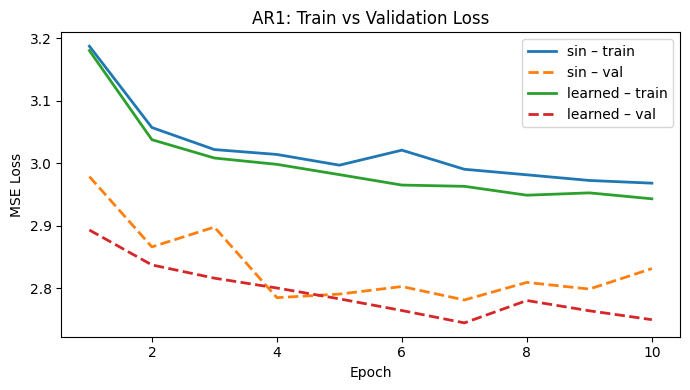

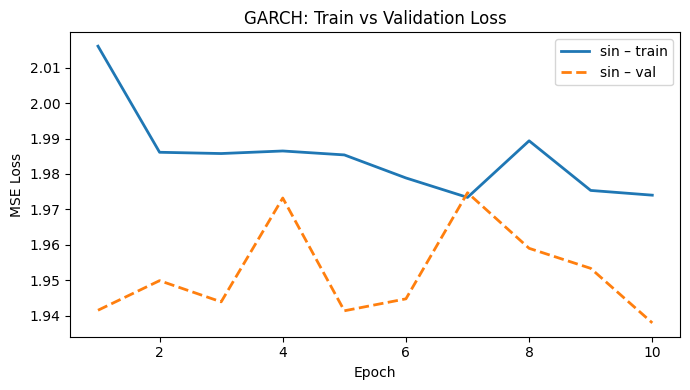

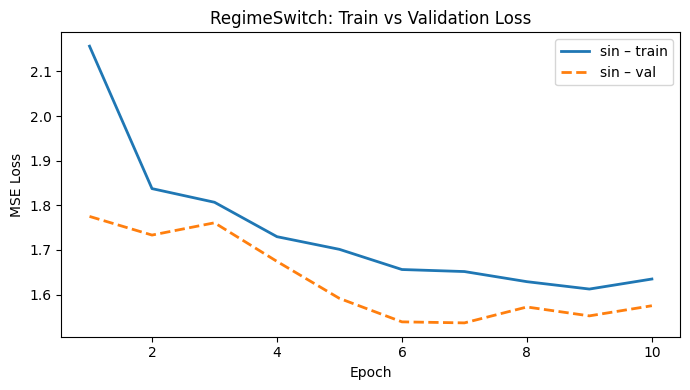

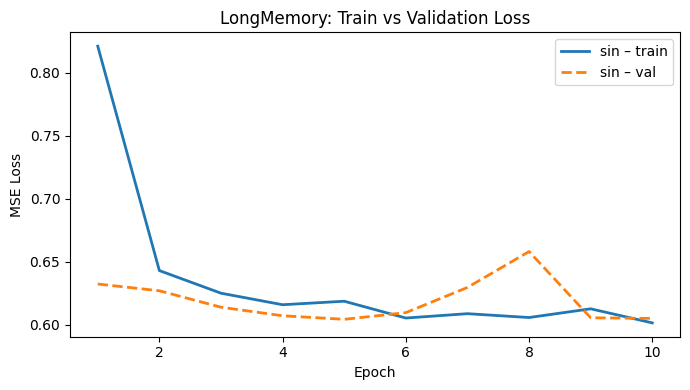

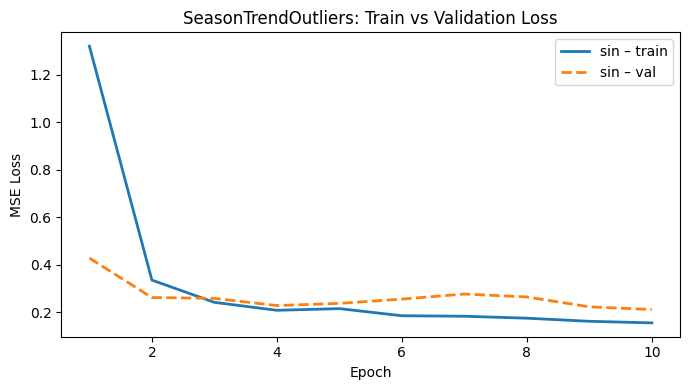

In [5]:
import matplotlib.pyplot as plt
def plot_family_histories(histories_by_family):
    """
    histories_by_family: dict of dicts
        {
            "AR1": {"sin": hist, "learned": hist},
            "GARCH": {"sin": hist},
            ...
        }
    """
    for family, variants in histories_by_family.items():
        plt.figure(figsize=(7, 4))
        for variant_name, hist in variants.items():
            epochs = range(1, len(hist["train_loss"]) + 1)
            plt.plot(
                epochs, hist["train_loss"],
                linestyle="-", linewidth=2,
                label=f"{variant_name} – train"
            )
            plt.plot(
                epochs, hist["val_loss"],
                linestyle="--", linewidth=2,
                label=f"{variant_name} – val"
            )
        plt.title(f"{family}: Train vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()


histories_by_family = {
    "AR1": {
        "sin": hist_A_sin,
        "learned": hist_A_learn,
    },
    "GARCH": {
        "sin": hist_B,
    },
    "RegimeSwitch": {
        "sin": hist_C,
    },
    "LongMemory": {
        "sin": hist_D,
    },
    "SeasonTrendOutliers": {
        "sin": hist_E,
    }
}

plot_family_histories(histories_by_family)



In [12]:
def rolling_one_step_forecast(
    model,
    series,
    input_len,
    device=None,
    input_dim_index=0,
    title="Rolling 1-step forecast",
):
    """
    Compute 1-step-ahead rolling forecasts over the entire series.

    Assumes pred_len = 1.

    Parameters
    ----------
    model : TimeSeriesTransformer
    series : np.ndarray or 1D tensor, shape (T,) or (T, N)
    input_len : int
        Length of history window used in training.
    device : str or None
    input_dim_index : int
        Which channel to use if multivariate.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure np array, shape (T, N)
    if torch.is_tensor(series):
        series = series.cpu().numpy()
    if series.ndim == 1:
        series = series[:, None]
    T, N = series.shape

    # Build ordered dataset over full series (stride=1)
    full_ds = SlidingWindowDataset(series, input_len=input_len, pred_len=1, stride=1)
    full_loader = DataLoader(full_ds, batch_size=256, shuffle=False)

    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X_batch, y_batch in full_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)

            # y_pred,y_batch : (B, 1, N)
            preds.append(y_pred[:, 0, input_dim_index].cpu().numpy())
            trues.append(y_batch[:, 0, input_dim_index].cpu().numpy())

    preds = np.concatenate(preds)   # length = num_windows
    trues = np.concatenate(trues)

    # Time indices: each window covers t..t+L-1, predicts t+L
    t_pred = np.arange(input_len, input_len + len(preds))  # 0-based

    df_forecast = pd.DataFrame(
        {
            "t": t_pred,
            "actual": trues,
            "pred": preds,
        }
    )

    # ---- Plot ----
    plt.figure(figsize=(10, 4))
    # full true series
    plt.plot(np.arange(T), series[:, input_dim_index], label="actual (full series)", alpha=0.4)
    # prediction region
    plt.plot(df_forecast["t"], df_forecast["actual"], label="actual (1-step target)", color="C1")
    plt.plot(df_forecast["t"], df_forecast["pred"], "--", label="1-step forecast", color="C2")

    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_forecast


=== AR1_sin ===


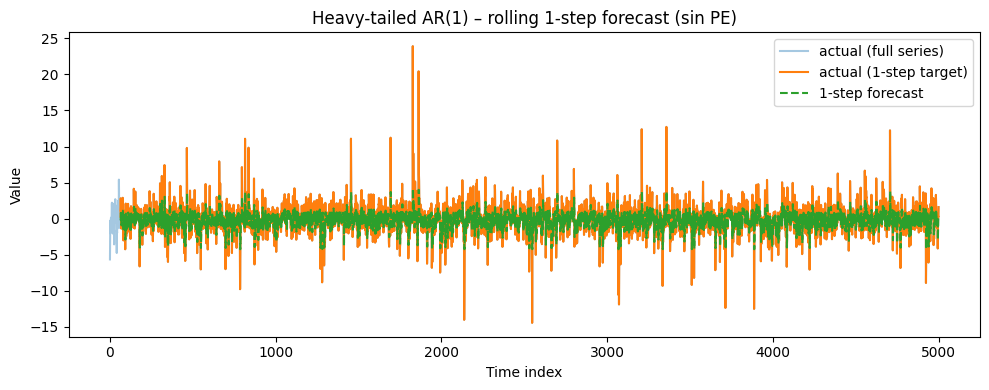


=== AR1_learned ===


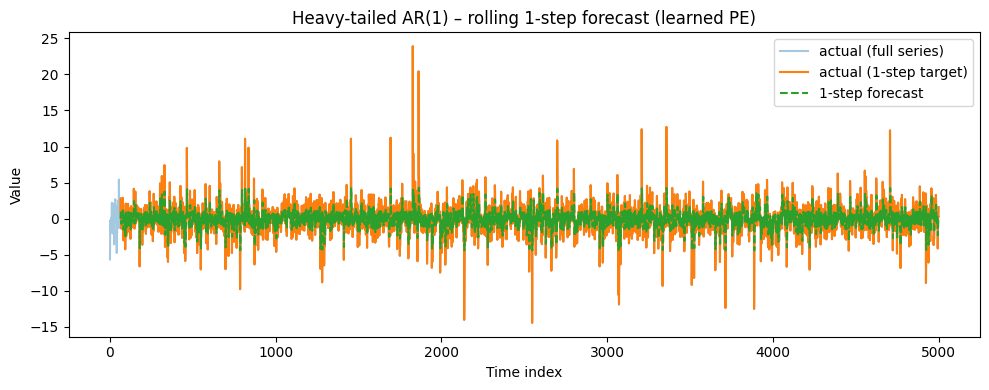


=== GARCH ===


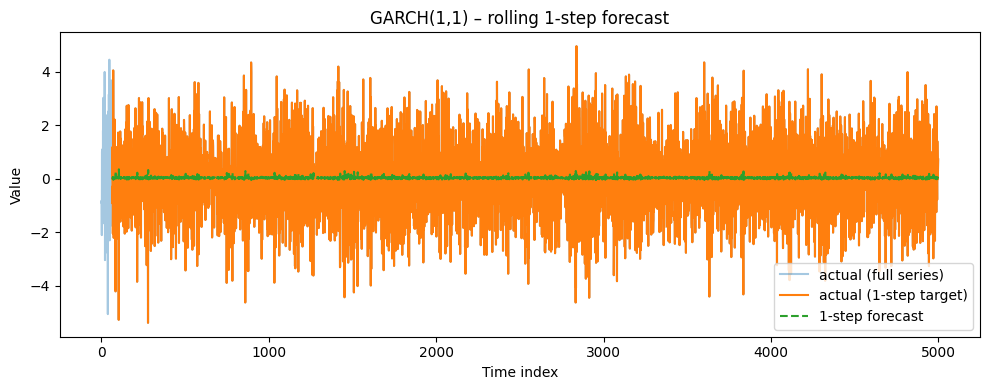


=== RegimeSwitch ===


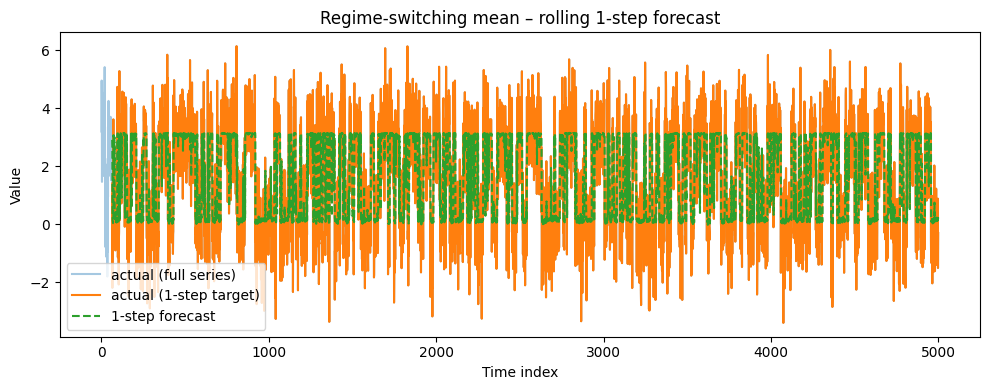


=== LongMemory ===


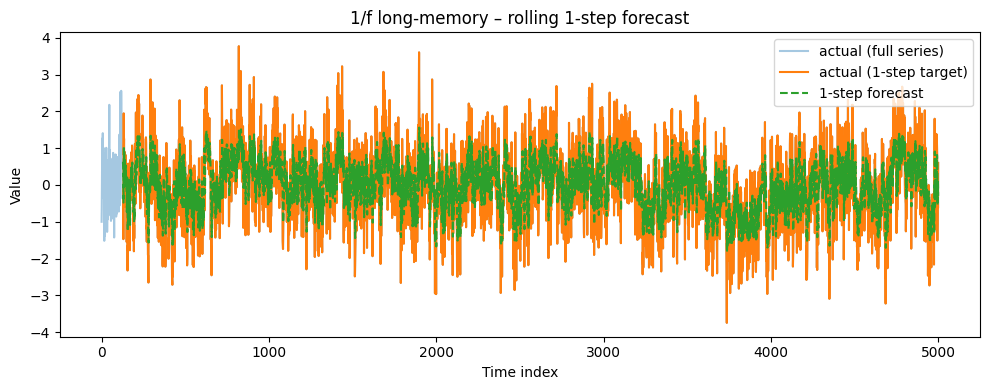


=== SeasonTrendOutliers ===


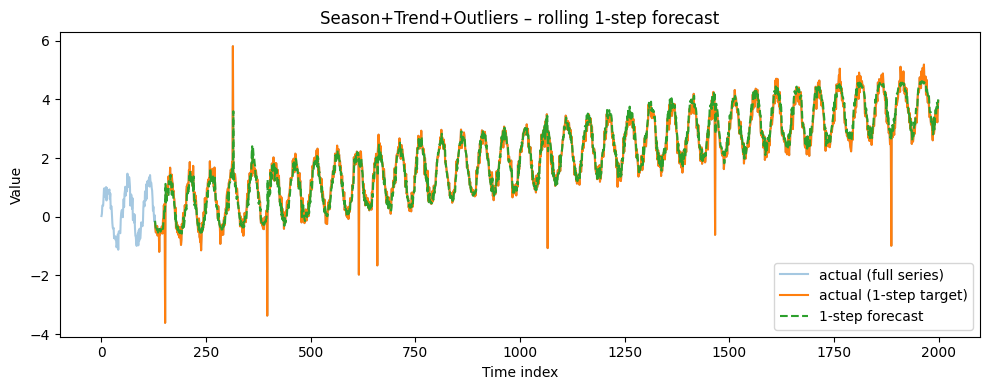

In [13]:
# ---------- Rolling 1-step forecasts for all synthetic families ----------

rolling_configs = {
    "AR1_sin": {
        "model": model_A_sin,
        "series": series_A,
        "input_len": 64,
        "title": "Heavy-tailed AR(1) – rolling 1-step forecast (sin PE)",
    },
    "AR1_learned": {
        "model": model_A_learn,
        "series": series_A,
        "input_len": 64,
        "title": "Heavy-tailed AR(1) – rolling 1-step forecast (learned PE)",
    },
    "GARCH": {
        "model": model_B,
        "series": series_B,
        "input_len": 64,
        "title": "GARCH(1,1) – rolling 1-step forecast",
    },
    "RegimeSwitch": {
        "model": model_C,
        "series": series_C,
        "input_len": 64,
        "title": "Regime-switching mean – rolling 1-step forecast",
    },
    "LongMemory": {
        "model": model_D,
        "series": series_D,
        "input_len": 128,
        "title": "1/f long-memory – rolling 1-step forecast",
    },
    "SeasonTrendOutliers": {
        "model": model_E,
        "series": series_E,
        "input_len": 128,
        "title": "Season+Trend+Outliers – rolling 1-step forecast",
    },
}

rolling_forecasts = {}

for name, cfg in rolling_configs.items():
    print(f"\n=== {name} ===")
    df_fore = rolling_one_step_forecast(
        model=cfg["model"],
        series=cfg["series"],
        input_len=cfg["input_len"],
        input_dim_index=0,
        title=cfg["title"],
    )
    rolling_forecasts[name] = df_fore
